<a href="https://colab.research.google.com/github/Aniket4301/Image-Classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting the g-drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing required librery

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import cv2,glob

In [3]:
# Path of the data set

input_path = Path('/content/drive/MyDrive/image classification data/all')
image_files = list(input_path.glob('*.jpg'))

In [4]:
# defining size for the image
im_size = (224,224)

In [5]:
from PIL import Image
from tqdm.notebook import tqdm

# function defining for read image and convert it into array

def file_read(fname):
    # Read image
    im = Image.open(fname)

    # Resize
    im.thumbnail(im_size)

    # Convert to numpy array
    im_array = np.asarray(im)

    # Get target
    target = int(fname.stem.split('_')[0])

    return im_array, target

In [6]:
## diffrentiate images and class by using file read function

images = []
targets = []

for image_file in tqdm(image_files):
    image, target = file_read(image_file)
    
    images.append(image)
    targets.append(target)

In [7]:
X = (np.array(images).astype(np.float32) / 127.5) - 1
y_cls = np.array(targets)

In [8]:
X.shape, y_cls.shape

((3059, 168, 224, 3), (3059,))

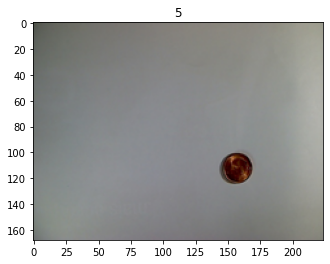

In [9]:
# showing any image from data set

i = 520
plt.imshow(np.uint8((X[i] + 1) * 127.5))
plt.title(str(y_cls[i]));

In [10]:
# creating dictionary and lebelling for class

coins_ids = {
    5: 0,
    10: 1,
    25: 2,
    50: 3,
    100: 4
}

ids_coins = [5, 10, 25, 50, 100]

y = np.array([coins_ids[coin] for coin in y_cls])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid, fname_train, fname_valid = train_test_split(
    X, y, image_files, test_size=0.3, random_state=42)

In [12]:
im_width = X.shape[2]
im_height = X.shape[1]

im_width, im_height

(224, 168)

In [13]:
from keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [14]:
model = Sequential()

# CNN network
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(im_height, im_width, 3)) )
model.add( MaxPool2D(2) )

model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(128, 3, activation='relu', padding='same') )
model.add( MaxPool2D(2) )

model.add( Conv2D(256, 3, activation='relu', padding='same') )

# Transition between CNN and MLP
model.add( GlobalAvgPool2D() )

# MLP network
model.add( Dense(256, activation='relu') )

model.add( Dense(5, activation='softmax') )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 168, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 112, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 112, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 28, 128)       7

In [15]:
optim = Adam(lr=1e-3)
model.compile(optim, 'sparse_categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
callbacks = [
    ReduceLROnPlateau(patience=5, factor=0.1, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=12)
]

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=32,
                   callbacks=callbacks)

Epoch 1/20
67/67 [==============================] - 17s 48ms/step - loss: 1.6104 - acc: 0.1922 - val_loss: 1.6058 - val_acc: 0.1939
INFO:tensorflow:Assets written to: best.model/assets
Epoch 2/20
67/67 [==============================] - 2s 30ms/step - loss: 1.4698 - acc: 0.3364 - val_loss: 1.0397 - val_acc: 0.5392
INFO:tensorflow:Assets written to: best.model/assets
Epoch 3/20
67/67 [==============================] - 2s 29ms/step - loss: 0.9866 - acc: 0.5932 - val_loss: 0.9134 - val_acc: 0.6438
INFO:tensorflow:Assets written to: best.model/assets
Epoch 4/20
67/67 [==============================] - 2s 29ms/step - loss: 0.8068 - acc: 0.6891 - val_loss: 0.8390 - val_acc: 0.7157
INFO:tensorflow:Assets written to: best.model/assets
Epoch 5/20
67/67 [==============================] - 2s 29ms/step - loss: 0.6252 - acc: 0.7901 - val_loss: 0.5860 - val_acc: 0.8453
INFO:tensorflow:Assets written to: best.model/assets
Epoch 6/20
67/67 [==============================] - 2s 30ms/step - loss: 0.5237

In [17]:
df_history = pd.DataFrame(history.history)

(0.9, 1.0)

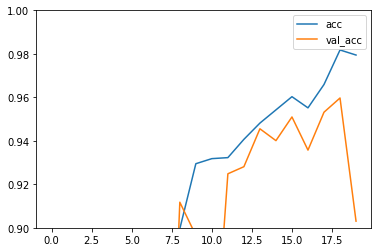

In [18]:
ax = df_history[['acc', 'val_acc']].plot()
ax.set_ylim(0.9, 1)

In [19]:
df_history['val_acc'].max()

0.9596949815750122

In [20]:
model.load_weights('best.model')

In [21]:
model.evaluate(X_valid, y_valid)

29/29 [==============================] - 0s 11ms/step - loss: 0.2091 - acc: 0.9532


[0.20905578136444092, 0.9531590342521667]

In [22]:
y_pred = model.predict(X_valid)

In [23]:
errors = np.where(y_pred != y_valid)[0]
errors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([0])

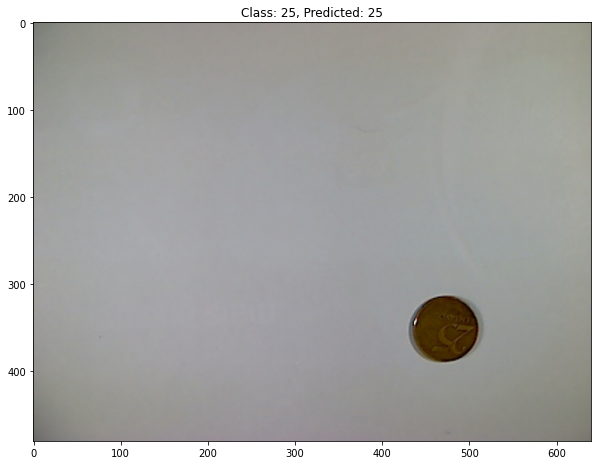

In [25]:
i = 100
plt.figure(figsize=(10, 10))
im = Image.open(fname_valid[i])
plt.imshow(np.uint8(im), interpolation='bilinear')
plt.title('Class: {}, Predicted: {}'.format(ids_coins[y_valid[i]], ids_coins[np.argmax(y_pred[i])]));